Shape = (10976, 30)
hour_ahead = 24
n_estimators = 150
learning_rate = 0.01
Depth = 10
Min_leaf = 256
0  7.556780457753312
1  7.512449382528582
2  7.468762360860365
3  7.425683742416945
4  7.383195394237363
5  7.33957629249342
6  7.29655120248426
7  7.254178202894247
8  7.212469683460458
9  7.17240941967227
10  7.131878607411437
11  7.092158818963851
12  7.052814707714767
13  7.014913717510842
14  6.9770275744145875
15  6.93955771304081
16  6.902567539247376
17  6.866535346436365
18  6.831117180188465
19  6.796937375958142
20  6.762198738765896
21  6.727980370237727
22  6.694386555330778
23  6.661339462904013
24  6.6289072225108265
25  6.596898733578839
26  6.565368315127296
27  6.535157478683746
28  6.504600306927777
29  6.4752521293991645
30  6.44552772043484
31  6.417095788472081
32  6.38913022199121
33  6.360741622918933
34  6.333611276846015
35  6.306046225134312
36  6.279615775016525
37  6.253601048264223
38  6.227335609654921
39  6.202203848869805
40  6.17743966701597
41  6.1524

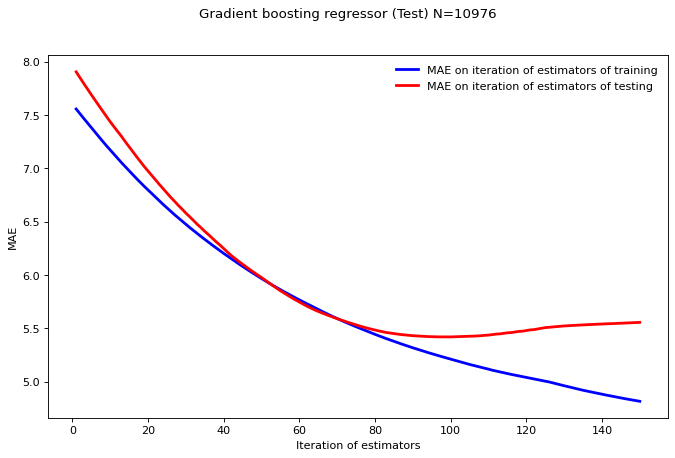

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 150
learning_rate = 0.01
Depth = 10
Min_leaf = 256


path = "/content/drive/MyDrive/Colab Notebooks/Project/star_data_set.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
Y = Y.to_numpy()
#Y.reset_index(drop=True, inplace=True)
#Y.columns = [''] * len(Y.columns)


X_temp1 = First['FI']
X_temp2 = First.loc[:, First.columns != 'FI']
#X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
#X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]
X = X.to_numpy()
#X.reset_index(drop=True, inplace=True)
#X.columns = [''] * len(X.columns)
Pred_index = X.shape
print("Shape = "+str(Pred_index))



X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
Insidetrain=[]
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
    Insidetrain.append(mean_absolute_error(y_train, predf))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

Insidetest =[]
i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
    Insidetest.append(mean_absolute_error(y_test, predf))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(Insidetrain))+1, Insidetrain, color="blue", linewidth=2.5, linestyle="-", label='MAE on iteration of estimators of training')
plt.plot(np.arange(len(Insidetest))+1, Insidetest, color="red",  linewidth=2.5, linestyle="-", label='MAE on iteration of estimators of testing')
plt.ylabel('MAE')
plt.xlabel('Iteration of estimators')
plt.legend(frameon=False)
plt.show()


Shape = (10976, 30)
hour_ahead = 24
n_estimators = 150
learning_rate = 0.01
Depth = 10
Min_leaf = 256
0  11.588307956436147
1  11.535737180719265
2  11.483979045912998
3  11.433023535227434
4  11.38286070211707
5  11.331856946844402
6  11.281644420389322
7  11.232214134000836
8  11.183526026873304
9  11.13686463262285
10  11.08951462269791
11  11.043125166586568
12  10.997251283548167
13  10.95350176977738
14  10.9092702259533
15  10.866394874216919
16  10.82352583113225
17  10.782224952337481
18  10.74151861357531
19  10.701781012215948
20  10.662047697215527
21  10.622960867437717
22  10.584511805383764
23  10.546691866809057
24  10.509878741286052
25  10.473595969669063
26  10.437756081668295
27  10.402922738728153
28  10.368234447187254
29  10.334531133671097
30  10.300973963463225
31  10.268373350909227
32  10.236327129496063
33  10.20430599077781
34  10.173364226359215
35  10.142384266210252
36  10.112461164066552
37  10.083061037695503
38  10.05358976400389
39  10.02526309923035

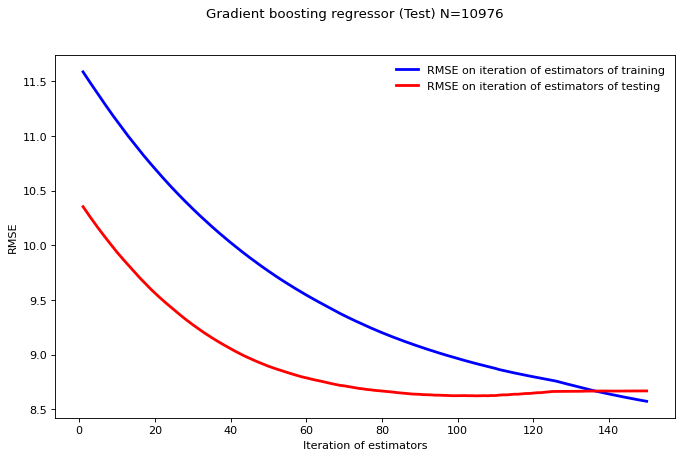

In [3]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 150
learning_rate = 0.01
Depth = 10
Min_leaf = 256


path = "/content/drive/MyDrive/Colab Notebooks/Project/star_data_set.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
Y = Y.to_numpy()
#Y.reset_index(drop=True, inplace=True)
#Y.columns = [''] * len(Y.columns)


X_temp1 = First['FI']
X_temp2 = First.loc[:, First.columns != 'FI']
#X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
#X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]
X = X.to_numpy()
#X.reset_index(drop=True, inplace=True)
#X.columns = [''] * len(X.columns)
Pred_index = X.shape
print("Shape = "+str(Pred_index))



X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
Insidetrain=[]
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_train, predf, squared=True))))
    Insidetrain.append(np.sqrt(mean_squared_error(y_train, predf, squared=True)))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

Insidetest =[]
i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_test, predf, squared=True))))
    Insidetest.append(np.sqrt(mean_squared_error(y_test, predf, squared=True)))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(Insidetrain))+1, Insidetrain, color="blue", linewidth=2.5, linestyle="-", label='RMSE on iteration of estimators of training')
plt.plot(np.arange(len(Insidetest))+1, Insidetest, color="red",  linewidth=2.5, linestyle="-", label='RMSE on iteration of estimators of testing')
plt.ylabel('RMSE')
plt.xlabel('Iteration of estimators')
plt.legend(frameon=False)
plt.show()
